# Introduction to Computational Science: Assignment 2
# Stochastic and Spatial Models
## Boyan Mihaylov & Sai Vinay Vardhan Daliparthi

This notebook documents the code used for the experiments conducted for Assignment 2 of the course "Introduction to Computational Science".

### 0. Prerequisites

The relevant libraries are imported below:

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

The Fourth-order Runge-Kutta method will be implemented as default numerical integration scheme for the deterministic SIR variants:

In [2]:
def runge_kutta(fun, x, step):
        """Fourth order Runge-Kutta method
        """
        k1 = fun(x)*step
        k2 = fun(x+0.5*k1)*step
        k3 = fun(x+0.5*k2)*step
        k4 = fun(x+k3)*step
        return x + (k1+2*k2+2*k3+k4)/6

### 1. Implementation of Gillespie's Algorithm

### 1.1. Deterministic benchmark
First, we recall the procedures used for the deterministic SIR model with demography and implement them here as a Python class.

As a refresher, the characteristic ODEs for this system are:

$$
\frac{dS}{dt}=\mu-\beta S I - \mu S \\
\frac{dI}{dt}=\beta S I - \gamma I - \mu I \\
\frac{dR}{dt}=\gamma I - \mu R
$$

The parameters $\beta$, $\gamma$ and $\mu$ can be supplied during class initialization directly, or calculated in the following way:

$\beta = -\kappa ln(1-C)$, where $\kappa$ is the number of individual contacts per unit time and $C$ is the probability of infection in the case of an infected contact.

$\gamma = 1/P_{inf}$ where $P_{inf}$ is the period of infection (in days).

$\mu = 1/L$, where $L$ is the expected lifespan of an individual (in days).

In [48]:
class InfectionModelDeterministic:
    """Basic class for the deterministic SIR model with demography
    """
    
    def __init__(self, X=999, Y=1, Z=0, k=None, c=None, pinf=None, lifespan=None, beta=None, gamma=None, mu=None):
        """Class initialization function. Beta, gamma and mu parameters can be provided directly
        or calculated via the parameters k, c, pinf and lifespan.
        """
        
        #print("Infection model initiated with: \n" + str(X) + " susceptible\n" + str(Y) + " infected\n" + str(Z) + " recovered\n")
        
        # Calculate beta and gamma depending on inputs
        if beta:
            self.beta=beta
        else:
            self.beta = -k*math.log(1-c)
        if gamma:
            self.gamma = gamma
        else:
            self.gamma = 1/pinf
        self.R0 = self.beta/self.gamma
        
        self.N = X+Y+Z
        self.S = X/self.N
        self.I = Y/self.N
        self.R = Z/self.N

        if mu:
            self.mu = mu
        else:
            self.mu = 1/lifespan
        
        self.R0 = self.beta/(self.gamma+self.mu)
        self.ode = self.SIR_d
    

    def SIR_d(self, sir):
        """Adds ODEs for demography model
        """
        
        self.dS = self.mu - self.beta*self.S*self.I - self.mu*self.S
        self.dI = self.beta*self.S*self.I - self.gamma*self.I - self.mu*self.I
        self.dR = self.gamma*self.I - self.mu*self.R
        
        return np.array([self.dS, self.dI, self.dR])
    
    
    def iterate(self, step, max_time, beta=None, gamma=None, constrain=True):
        """Numerical integration of the population fractions
        """
        
        # Assign native beta and gamma unless overriden
        if beta: self.beta = beta
        else: beta = self.beta
        if gamma: self.gamma = gamma
        else: gamma = self.gamma
        
        S_track = []
        I_track = []
        R_track = []
        time_track = []
        
        time_elapsed = 0
        while time_elapsed < max_time:
            
            # Constrain to range 0 to 1
            if constrain:
                if self.S < 0: self.S = 0
                elif self.S > 1: self.S = 1
                if self.I < 0: self.I = 0
                elif self.I > 1: self.I = 1
                if self.R < 0: self.R = 0
                elif self.R > 1: self.R = 1
            
            S_track.append(self.S)
            I_track.append(self.I)
            R_track.append(self.R)
            time_track.append(time_elapsed)
            self.S, self.I, self.R = runge_kutta(self.ode, np.array([self.S,self.I,self.R]),step)
            
            time_elapsed += step
        
        return time_track, S_track, I_track, R_track

### 1.2. Stochastic SIR

Next a new type of infection model class is constructed, which implements Gillespie's Direct Algorithm.

The basic rate parameters $\beta$, $\gamma$ and $\mu$ are defined and stored in the same way as in the deterministic model. The population compartments will no more be represented by the fractions $S$, $I$ and $R$ but rather by the absolute numbers of individuals $X$, $Y$ and $Z$.

In [4]:
class InfectionModelStochastic:
    """Basic class for the stochastic SIR model with demography
    """
    
    def __init__(self, X=999, Y=1, Z=0, k=None, c=None, pinf=None, lifespan=None, beta=None, gamma=None, mu=None):
        """Class initialization function. Beta and gamma parameters can be provided directly
        or calculated via the parameters k, c and pinf.
        """
        
        #print("Infection model initiated with: \n" + str(X) + " susceptible\n" + str(Y) + " infected\n" + str(Z) + " recovered\n")
        
        # Calculate beta, gamma and mu depending on inputs
        if beta: self.beta=beta
        else: self.beta = -k*math.log(1-c)

        if gamma: self.gamma = gamma
        else: self.gamma = 1/pinf

        if mu: self.mu = mu
        else: self.mu = 1/lifespan
        
        # Assign population numbers
        self.X = X
        self.Y = Y
        self.Z = Z
        self.N = X+Y+Z
        
        # Calculate R0
        self.R0 = self.beta/(self.gamma+self.mu)

        # Define possible events and their starting rates
        self.events = {
            'birth': self.mu*self.N,
            'transmission': self.beta*self.X*self.Y/self.N,
            'recovery': self.gamma*self.Y,
            'deathX': self.mu*self.X,
            'deathY': self.mu*self.Y,
            'deathZ': self.mu*self.Z
        }
        
        # Assign iteration scheme
        self.iter_scheme = self.iteration_GDA
    

    def update_rates(self):
        """Updates different event rates based on current population sizes.
        """

        self.events['birth'] = self.mu*self.N
        self.events['transmission'] = self.beta*self.X*self.Y/self.N
        self.events['recovery'] = self.gamma*self.Y
        self.events['deathX'] = self.mu*self.X
        self.events['deathY'] = self.mu*self.Y
        self.events['deathZ'] = self.mu*self.Z
    

    def update_population(self, event_key):
        """Updates compartment numbers based on selected event
        """

        if event_key == 'birth':
             self.X += 1
        elif event_key == 'transmission' and self.X > 0:
            self.X -= 1
            self.Y += 1
        elif event_key == 'recovery' and self.Y > 0:
            self.Y -= 1  
            self.Z += 1     
        elif event_key == 'deathX' and self.X > 0:
            self.X -= 1
        elif event_key == 'deathY' and self.Y > 0:
            self.Y -= 1
        elif event_key == 'deathZ' and self.Z > 0:
            self.Z -= 1
        
        self.N = self.X + self.Y + self.Z

        self.update_rates()


    def iteration_GDA(self):
        """Performs a single event iteration of Gillespie's Direct Algorithm.
        """

        # The rate at which any event occurs
        rates_total = sum(self.events.values())

        # Time until next event
        dt = -math.log(np.random.uniform(0,1))/rates_total

        # Event selector
        event_sel = np.random.uniform(0, rates_total)

        # Pick event using selector
        running_sum = 0
        selected_key = None
        for event_key in self.events:
            if event_sel > running_sum and event_sel <= running_sum + self.events[event_key]:
                selected_key = event_key
                break
            running_sum += self.events[event_key]

        # Perform event
        self.update_population(selected_key)

        # Return time step
        return dt


    def iterate(self, maxtime):
        """Performs multiple iterations of stochastic algorithm
        over a specified time frame.
        """

        time_current = 0
        iter_ct = 0
        max_iter = 100000

        time_track = []
        X_track = []
        Y_track = []
        Z_track = []

        while time_current < maxtime and iter_ct < max_iter:

            # Track values
            time_track.append(time_current)
            X_track.append(self.X)
            Y_track.append(self.Y)
            Z_track.append(self.Z)

            # Perform single event step
            dt = self.iter_scheme()

            time_current += dt
            iter_ct += 1
        
        return time_track, X_track, Y_track, Z_track

The stochasic model can now be put into use in a first test run. We are using the following parameter values:

$$
\kappa = 8\\
C = 0.1\\
P_{inf} = 7\\
L = 16107.525
$$

The infectious period and the lifespan are thus both brought to a scale of days, with the period of infection corresponding to one week and the life expectancy equivalent to 44.1 years (median EU age for 2011 according to Eurostat).

A time limit of 90 days will be set for the simulation. Furthermore, to capture a broader picture of the behaviour of the system, ten separate runs are simultaneously plotted using different random seeds. To align the time-grids of all plots and overcome the issue of inconsistent time-steps, the traced values are re-sampled using a quarter-day grid. This facilitates the visualisation of the error range the collection of runs.

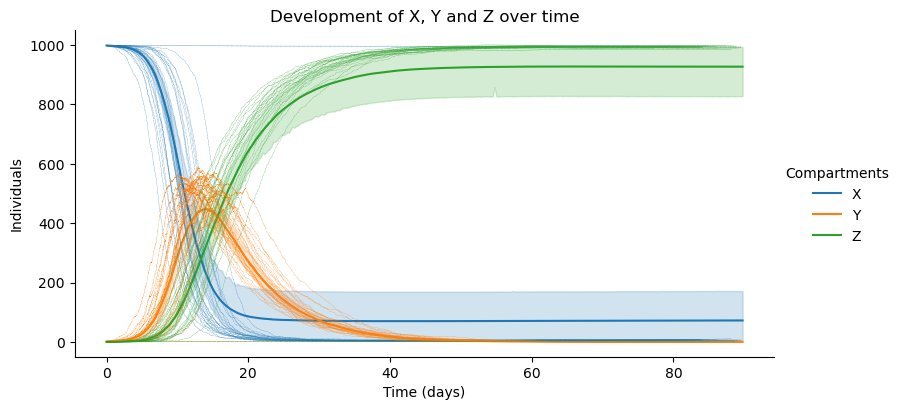

In [51]:
# Range of random seeds
seed_range = np.arange(0, 30, 1)

# Global simulation parameters
maxtime = 90 # days
X_start = 999
Y_start = 1
Z_start = 0

# DataFrame for storing data from runs
array_runs = np.array([[seed_range[0], 0, X_start, Y_start, Z_start]]).T
array_runs_interp = array_runs[:]

# Resample time in quarter-day intervals
time_resample = np.arange(0, maxtime, 0.25)

for s in seed_range:
    
    np.random.seed(s)

    stochastic_SIR = InfectionModelStochastic(X_start, Y_start, Z_start, k=8, c=0.1, pinf=7, lifespan=16107.525)

    time_track, X_track, Y_track, Z_track = stochastic_SIR.iterate(maxtime)

    values_track = np.vstack([time_track, X_track, Y_track, Z_track])
    values_head = np.full([1,values_track.shape[1]], s)
    array_runs = np.append(array_runs, np.concatenate((values_head, values_track), axis=0), axis=1)

    # Interpolate (resample) values
    X_interp = np.interp(time_resample, time_track, X_track)
    Y_interp = np.interp(time_resample, time_track, Y_track)
    Z_interp = np.interp(time_resample, time_track, Z_track)
    values_interp = np.vstack([time_resample, X_interp, Y_interp, Z_interp])
    values_interp_head = np.full([1,values_interp.shape[1]], s)
    array_runs_interp = np.append(array_runs_interp, np.concatenate((values_interp_head, values_interp), axis=0), axis=1)


# Construct DataFrames
df_runs = pd.DataFrame(array_runs.T, columns=['seed','time','X','Y','Z'])
df_runs_melt = df_runs.melt(['time','seed'], var_name='Compartments', value_name='vals')
df_runs_interp = pd.DataFrame(array_runs_interp.T, columns=['seed','time','X','Y','Z'])
df_runs_interp_melt = df_runs_interp.melt(['time','seed'], var_name='Compartments', value_name='vals')

# Plot
sns.relplot(df_runs_interp_melt, x='time', y='vals', kind='line', hue='Compartments', height=4, aspect=2.)
sns.lineplot(df_runs_melt, x='time', y='vals', hue='Compartments', style='seed', legend=False, linewidth=0.2)
plt.xlabel('Time (days)')
plt.ylabel('Individuals')
plt.title('Development of X, Y and Z over time')
plt.show()

Several observations can be made:
- Generally consistent equilibria are present;
- The distributions get skewed by occasional extinctions;
- The timing of the peak of infection exhibits some variation.

The results can be compared with the plots from the deterministic model with an equivalent setting:

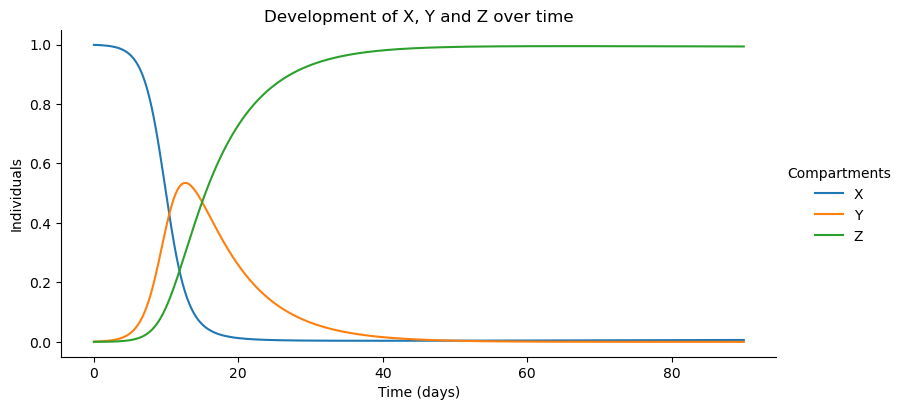

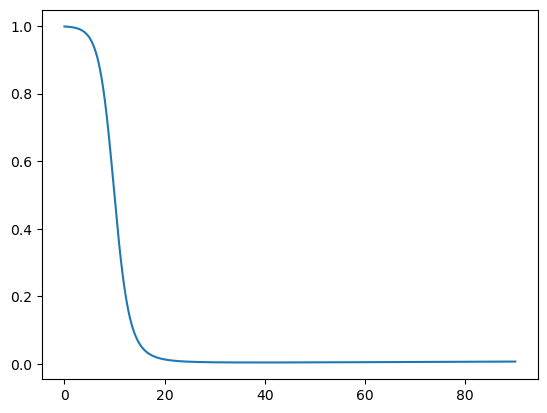

In [49]:
# Global simulation parameters
step = 10e-2
maxtime = 90 # days
X_start = 999
Y_start = 1
Z_start = 0

# Initialise and run deterministic model
deterministic_SIR = InfectionModelDeterministic(X_start, Y_start, Z_start, k=8, c=0.1, pinf=7, lifespan=16107.525)

values_track = np.vstack(deterministic_SIR.iterate(step, maxtime))

# Construct DataFrames
df_run = pd.DataFrame(values_track.T, columns=['time','X','Y','Z'])
df_run_melt = df_run.melt('time', var_name='Compartments', value_name='vals')

# Plot
sns.relplot(df_run_melt, x='time', y='vals', kind='line', hue='Compartments', height=4, aspect=2.)
plt.xlabel('Time (days)')
plt.ylabel('Individuals')
plt.title('Development of X, Y and Z over time')
plt.show()